In [0]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
import base64
import string
from argparse import ArgumentParser
from io import open, BytesIO
from os import environ, path, makedirs
from zlib import compress
from PIL import Image
import matplotlib.pyplot as plt
import httplib2
import six
from six.moves.urllib.parse import urlencode

In [0]:
relationships = [ 
# Add table relationships   
             
{"primary": "promo_analytics.rewards.id", "secondary": "promo_analytics.reward_events.id", "relation": "||--|{", "type": "ASSOCIATED_WITH", "description": ""},

{"primary": "promo_analytics.rewards.id", "secondary": "promo_analytics.promo_codes_applied.id", "relation": "||--||", "type": "CONTAINS", "description": ""},

{"primary": "promo_analytics.rewards.id", "secondary": "promo_analytics.promo_holdings.reward_id", "relation": "||--||", "type": "ASSOCIATED_WITH", "description": ""},

{"primary": "promo_analytics.rewards.id", "secondary": "promo_analytics.promo_holdings_extended.reward_id", "relation": "||--||", "type": "ASSOCIATED_WITH", "description": ""},

{"primary": "promo_analytics.promo_holdings.id", "secondary": "promo_analytics.promo_holdings_extended.id", "relation": "||--||", "type": "ASSOCIATED_WITH", "description": ""},

{"primary": "promo_analytics.promo_holdings.id", "secondary": "promo_analytics.promo_holding_events.id", "relation": "||--|{", "type": "ASSOCIATED_WITH", "description": ""},

{"primary": "promo_analytics.promo_code_campaign_configs.id", "secondary": "promo_analytics.promo_codes_applied.campaign_config_id", "relation": "||--|{", "type": "CONTAINS", "description": ""},

{"primary": "promo_analytics.promo_campaigns.id", "secondary": "promo_analytics.promo_code_campaign_configs.campaign_id", "relation": "||--|{", "type": "CONTAINS", "description": ""},

{"primary": "promo_analytics.promo_campaigns.id", "secondary": "promo_analytics.promo_campaign_codes.campaign_id", "relation": "||--|{", "type": "CONTAINS", "description": ""},

{"primary": "promo_analytics.active_months.id", "secondary": "promo_analytics.active_month_events.campaign_id", "relation": "||--|{", "type": "CONTAINS", "description": ""}
 
]

display(pd.DataFrame(relationships))

primary,secondary,relation,type,description
promo_analytics.rewards.id,promo_analytics.reward_events.id,||--|{,ASSOCIATED_WITH,
promo_analytics.rewards.id,promo_analytics.promo_codes_applied.id,||--||,CONTAINS,
promo_analytics.rewards.id,promo_analytics.promo_holdings.reward_id,||--||,ASSOCIATED_WITH,
promo_analytics.rewards.id,promo_analytics.promo_holdings_extended.reward_id,||--||,ASSOCIATED_WITH,
promo_analytics.promo_holdings.id,promo_analytics.promo_holdings_extended.id,||--||,ASSOCIATED_WITH,
promo_analytics.promo_holdings.id,promo_analytics.promo_holding_events.id,||--|{,ASSOCIATED_WITH,
promo_analytics.promo_code_campaign_configs.id,promo_analytics.promo_codes_applied.campaign_config_id,||--|{,CONTAINS,
promo_analytics.promo_campaigns.id,promo_analytics.promo_code_campaign_configs.campaign_id,||--|{,CONTAINS,
promo_analytics.promo_campaigns.id,promo_analytics.promo_campaign_codes.campaign_id,||--|{,CONTAINS,
promo_analytics.active_months.id,promo_analytics.active_month_events.campaign_id,||--|{,CONTAINS,


In [0]:
# Get all databases

databases = [row.databaseName for row in spark.sql(f"show databases").select('databaseName').collect()]

In [0]:
# Define PlantUML class

if six.PY2:
    from string import maketrans
else:
    maketrans = bytes.maketrans


plantuml_alphabet = string.digits + string.ascii_uppercase + string.ascii_lowercase + '-_'
base64_alphabet   = string.ascii_uppercase + string.ascii_lowercase + string.digits + '+/'
b64_to_plantuml = maketrans(base64_alphabet.encode('utf-8'), plantuml_alphabet.encode('utf-8'))


class PlantUMLError(Exception):
    """
    Error in processing.
    """
    pass


class PlantUMLConnectionError(PlantUMLError):
    """
    Error connecting or talking to PlantUML Server.
    """
    pass


class PlantUMLHTTPError(PlantUMLConnectionError):
    """
    Request to PlantUML server returned HTTP Error.
    """

    def __init__(self, response, content, *args, **kwargs):
        self.response = response
        self.content = content
        message = "%d: %s" % (self.response.status, self.response.reason)
        if not getattr(self, 'message', None):
            self.message = message
        super(PlantUMLHTTPError, self).__init__(message, *args, **kwargs)


def deflate_and_encode(plantuml_text):
    """zlib compress the plantuml text and encode it for the plantuml server.
    """
    zlibbed_str = compress(plantuml_text.encode('utf-8'))
    compressed_string = zlibbed_str[2:-4]
    return base64.b64encode(compressed_string).translate(b64_to_plantuml).decode('utf-8')


class PlantUML(object):
    """Connection to a PlantUML server with optional authentication.
    
    All parameters are optional.
    
    :param str url: URL to the PlantUML server image CGI. defaults to
                    http://www.plantuml.com/plantuml/img/
    :param dict basic_auth: This is if the plantuml server requires basic HTTP
                    authentication. Dictionary containing two keys, 'username'
                    and 'password', set to appropriate values for basic HTTP
                    authentication.
    :param dict form_auth: This is for plantuml server requires a cookie based
                    webform login authentication. Dictionary containing two
                    primary keys, 'url' and 'body'. The 'url' should point to
                    the login URL for the server, and the 'body' should be a
                    dictionary set to the form elements required for login.
                    The key 'method' will default to 'POST'. The key 'headers'
                    defaults to
                    {'Content-type':'application/x-www-form-urlencoded'}.
                    Example: form_auth={'url': 'http://example.com/login/',
                    'body': { 'username': 'me', 'password': 'secret'}
    :param dict http_opts: Extra options to be passed off to the
                    httplib2.Http() constructor.
    :param dict request_opts: Extra options to be passed off to the
                    httplib2.Http().request() call.
                    
    """

    def __init__(self, url="http://www.plantuml.com/plantuml/img/", basic_auth={}, form_auth={},
                 http_opts={}, request_opts={}):
        self.HttpLib2Error = httplib2.HttpLib2Error
        self.url = url
        self.request_opts = request_opts
        self.auth_type = 'basic_auth' if basic_auth else (
            'form_auth' if form_auth else None)
        self.auth = basic_auth if basic_auth else (
            form_auth if form_auth else None)

        # Proxify
        try:
            from urlparse import urlparse
            import socks

            proxy_uri = urlparse(environ.get('HTTPS_PROXY', environ.get('HTTP_PROXY')))
            if proxy_uri:
                proxy = {'proxy_info': httplib2.ProxyInfo(socks.PROXY_TYPE_HTTP, proxy_uri.hostname, proxy_uri.port)}
                http_opts.update(proxy)
                self.request_opts.update(proxy)
        except ImportError:
            pass

        self.http = httplib2.Http(**http_opts)

        if self.auth_type == 'basic_auth':
            self.http.add_credentials(
                self.auth['username'], self.auth['password'])
        elif self.auth_type == 'form_auth':
            if 'url' not in self.auth:
                raise PlantUMLError(
                    "The form_auth option 'url' must be provided and point to "
                    "the login url.")
            if 'body' not in self.auth:
                raise PlantUMLError(
                    "The form_auth option 'body' must be provided and include "
                    "a dictionary with the form elements required to log in. "
                    "Example: form_auth={'url': 'http://example.com/login/', "
                    "'body': { 'username': 'me', 'password': 'secret'}")
            login_url = self.auth['url']
            body = self.auth['body']
            method = self.auth.get('method', 'POST')
            headers = self.auth.get(
                'headers', {'Content-type': 'application/x-www-form-urlencoded'})
            try:
                response, content = self.http.request(
                    login_url, method, headers=headers,
                    body=urlencode(body))
            except self.HttpLib2Error as e:
                raise PlantUMLConnectionError(e)
            if response.status != 200:
                raise PlantUMLHTTPError(response, content)
            self.request_opts['Cookie'] = response['set-cookie']

    def get_url(self, plantuml_text):
        """Return the server URL for the image.
        You can use this URL in an IMG HTML tag.
        
        :param str plantuml_text: The plantuml markup to render
        :returns: the plantuml server image URL
        """
        return self.url + deflate_and_encode(plantuml_text)

    def processes(self, plantuml_text):
        """Processes the plantuml text into the raw PNG image data.
        
        :param str plantuml_text: The plantuml markup to render
        :returns: the raw image data
        """
        url = self.get_url(plantuml_text)
        try:
            response, content = self.http.request(url, **self.request_opts)
        except self.HttpLib2Error as e:
            raise PlantUMLConnectionError(e)
        if response.status != 200:
            raise PlantUMLHTTPError(response, content)
        return content
      
    def show_plantuml(self, plantuml_text, scale=1.0):
        data = self.processes(plantuml_text)
        image = Image.open(BytesIO(data))
        image.save("/dbfs/FileStore/plots/erd.png")
        image_size = (round(image.size[0] * scale), round(image.size[1] * scale))
        #print(image_size)
        plt.figure(figsize = image_size)
        plt.imshow(image, interpolation='nearest', aspect='auto')

In [0]:
# PlantUML string 
spark = SparkSession.builder.appName("Database Schema Generator").getOrCreate()

def generate_plantuml_text(dpi=80, ranksep=150, nodesep=10, left_to_right = True, show_fields=True, show_databases=True):
  direction = "left to right direction" if left_to_right else "top to bottom direction"
  plantuml_text = f"""@startuml
  !define primary_key(x) <b><color:#b8861b><&key></color> x</b>
  !define foreign_key(x) <b><color:#aaaaaa><&key></color> x</b>
  !define column(x) <color:#efefef><&media-record></color> x
  
  ' hide the spot
  hide circle

  ' avoid problems with angled crows feet
  skinparam linetype ortho
  
  {direction}
  skinparam dpi {dpi}
  skinparam ranksep {ranksep}
  skinparam nodesep {nodesep}
  skinparam roundcorner 10
  skinparam shadowing true
  skinparam defaultFontName Broadway
  skinparam class {{
    BackgroundColor #D3D3D3
    ArrowColor black
    BorderColor black
  }}
  skinparam package {{
    BackgroundColor #F5F5F5
  }}

  """  # PlantUML header
  
  widget_text = "Choose tables to create ERD for"
  databases = [row.databaseName for row in spark.sql(f"show databases").select('databaseName').collect()]  # Get all databases
  tables = [item for sublist in [[f"{database}.{row.tableName}" for row in spark.sql(f"show tables in `{database}`").collect() if not row.isTemporary and not row.tableName.startswith('vw_') and not row.tableName.startswith('bronze_')] for database in databases] for item in sublist]  # Get all tables
  dbutils.widgets.multiselect(widget_text, "promo_analytics.rewards", tables)  # Input tables at the top of the notebook

  selected_tables = dbutils.widgets.get(widget_text).split(',')  # Tables to list format
  selected_databases = set([table.split(".")[0] for table in selected_tables])
  
  df = pd.DataFrame(relationships)
  df = df.loc[df['primary'].apply(lambda x: ".".join(x.split(".")[:2])).isin(selected_tables) * df['secondary'].apply(lambda x: ".".join(x.split(".")[:2])).isin(selected_tables)]
  keys_lookup = {}
  for i, row in df.iterrows():
    primary_table = ".".join(row.primary.split(".")[:2])
    primary_table_key = row.primary.split(".")[-1] if len(row.primary.split(".")) > 2 else False
    if primary_table_key:
      if primary_table not in keys_lookup.keys():
        keys_lookup[primary_table] = [primary_table_key]
      else:
        keys_lookup[primary_table].append(primary_table_key)
        
    secondary_table = ".".join(row.secondary.split(".")[:2])
    secondary_table_key = row.secondary.split(".")[-1] if len(row.secondary.split(".")) > 2 else False
    if secondary_table_key:
      if secondary_table not in keys_lookup.keys():
        keys_lookup[secondary_table] = [secondary_table_key]
      else:
        keys_lookup[secondary_table].append(secondary_table_key)
  
  # Add all the tables
  added_tables = []
  for database in [database for database in databases if database in selected_databases]: 
    if show_databases:
      plantuml_text += f'package "{database}" {{\n'
    for table in [row.tableName for row in spark.sql(f"show tables in `{database}`").collect() if not row.isTemporary and not row.tableName.startswith('vw_') and not row.tableName.startswith('bronze_')]:   
      if f"{database}.{table}" in selected_tables or not database in set([table.split('.')[0] for table in selected_tables]):
        try:  
          fields = sorted([(row.col_name, row.data_type) for row in spark.sql(f"describe table `{database}`.`{table}`").collect() if not row.col_name in ['', '# Partitioning', 'Part 0', 'Not partitioned']], key=lambda x: x[0])
          keys = [i for i in fields if i[0] in keys_lookup.get(f"{database}.{table}", [])] 
          keys = [i for i in keys if i[0] == "id"] + [i for i in keys if i[0] != "id"] if "id" in [i[0] for i in keys] else keys 
          fields = keys + [i for i in fields if i[0] not in keys_lookup.get(f"{database}.{table}", [])] 
          
          plantuml_text += f'entity "{table}" {{\n' if show_databases else f'entity "{database}.{table}" {{\n'
          if show_fields:
            if len(keys) == 0: 
                plantuml_text += "--\n" 
            for i, (field, dtype) in enumerate(fields):  
              if dtype.startswith("struct"):  
                dtype = "struct"
              elif dtype.startswith("array<struct"):
                dtype = "array<struct>"
              dtype = dtype.upper()
              plantuml_text += f"primary_key({field}) : {dtype}\n" if field == "id" else (f"foreign_key({field}) : {dtype}\n" if field in [k[0] for k in keys] else f"column({field}) : {dtype}\n")
              if i == len(keys) - 1: 
                plantuml_text += "--\n" 
          plantuml_text += "}\n\n"
          added_tables.append(f"{table}" if show_databases else f"{database}.{table}")  
        except AnalysisException:
          pass
    if show_databases:
      plantuml_text += "}\n"

  for relationship in relationships:
    first_table = relationship["primary"].split(".")[1] if show_databases else ".".join(relationship["primary"].split(".")[:2])
    second_table = relationship["secondary"].split(".")[1] if show_databases else ".".join(relationship["secondary"].split(".")[:2])
    if (first_table in added_tables and second_table in added_tables): 
      plantuml_text += f"{first_table} {relationship['relation']} {second_table} : {relationship['type']}\n"

  plantuml_text += "@enduml"
  return plantuml_text

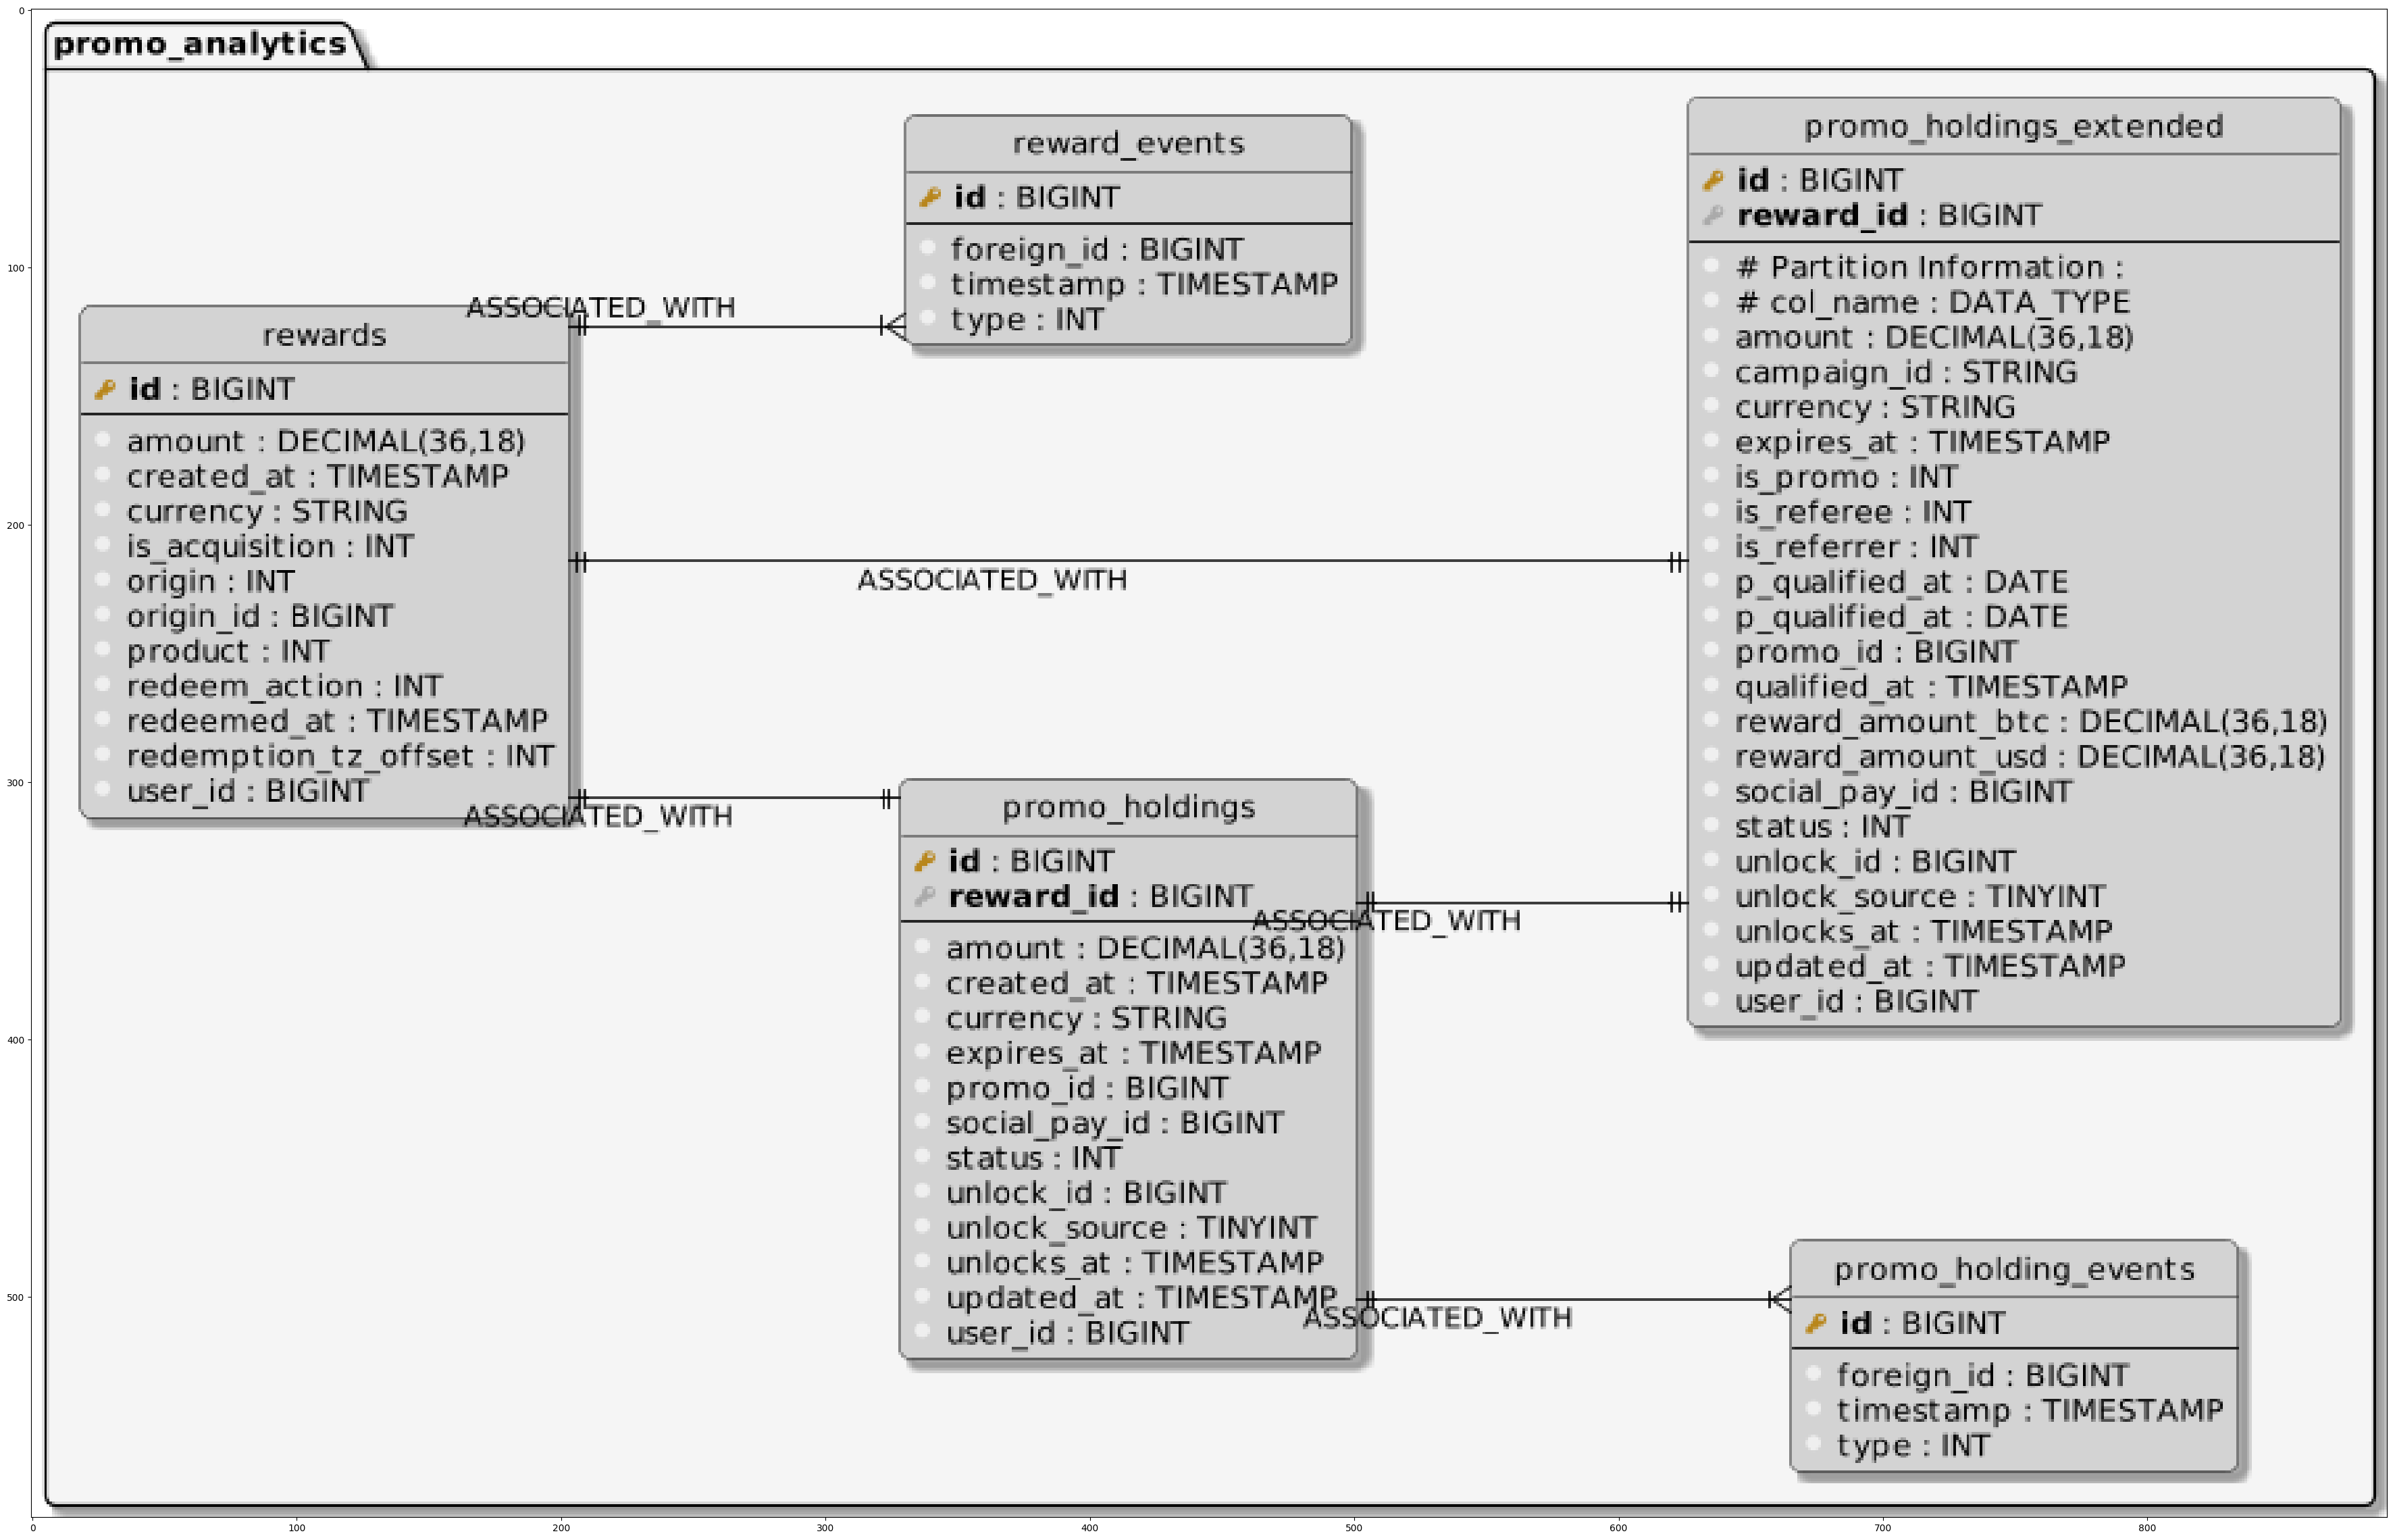

In [0]:
# Generate ERD as and image

plantuml = PlantUML()
plantuml_text = generate_plantuml_text(dpi=80,
                                       ranksep=150,
                                       nodesep=100,
                                       left_to_right=True,
                                       show_fields=True,
                                       show_databases=False)
plantuml.show_plantuml(plantuml_text, scale=0.05)